In [6]:
import numpy as np
import matplotlib.pyplot as plt
import yasa
import pandas as pd
import mne
from mne.datasets.sleep_physionet.age import fetch_data
from mne.time_frequency import psd_welch

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

In [7]:
ALICE, BOB = 0, 1

[alice_files, bob_files] = fetch_data(subjects=[ALICE, BOB], recording=[1])
print(alice_files)

raw_train = mne.io.read_raw_edf(alice_files[0], stim_channel='Event marker',
                                misc=['Temp rectal'])
annot_train = mne.read_annotations(alice_files[1])

raw_train.set_annotations(annot_train, emit_warning=False)

Using default location ~/mne_data for PHYSIONET_SLEEP...
['/net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001E0-PSG.edf', '/net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001EC-Hypnogram.edf']
Extracting EDF parameters from /net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


'\n# plot some data\n# scalings were chosen manually to allow for simultaneous visualization of\n# different channel types in this specific dataset\nraw_train.plot(start=60, duration=60,\n               scalings=dict(eeg=1e-4, resp=1e3, eog=1e-4, emg=1e-7,\n                             misc=1e-1)\n'

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


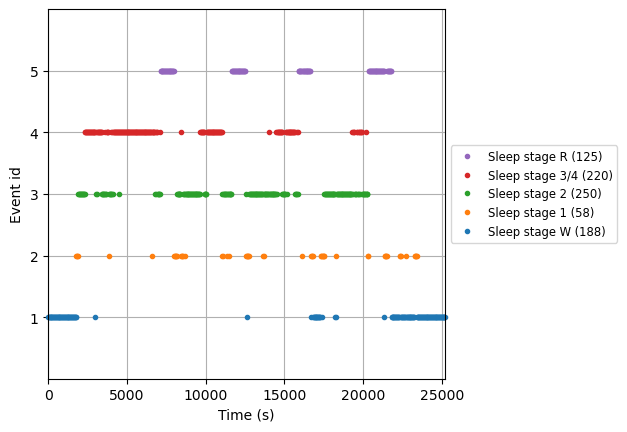

In [8]:
annotation_desc_2_event_id = {'Sleep stage W': 1,
                              'Sleep stage 1': 2,
                              'Sleep stage 2': 3,
                              'Sleep stage 3': 4,
                              'Sleep stage 4': 4,
                              'Sleep stage R': 5}

# keep last 30-min wake events before sleep and first 30-min wake events after
# sleep and redefine annotations on raw data
annot_train.crop(annot_train[1]['onset'] - 30 * 60,
                 annot_train[-2]['onset'] + 30 * 60)
raw_train.set_annotations(annot_train, emit_warning=False)

events_train, _ = mne.events_from_annotations(
    raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

# create a new event_id that unifies stages 3 and 4
event_id = {'Sleep stage W': 1,
            'Sleep stage 1': 2,
            'Sleep stage 2': 3,
            'Sleep stage 3/4': 4,
            'Sleep stage R': 5}

# keep the color-code for further plotting
stage_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
tmax = 30. - 1. / raw_train.info['sfreq']  # tmax in included

epochs_train = mne.Epochs(raw=raw_train, events=events_train,
                          event_id=event_id, tmin=0., tmax=tmax, baseline=None)

print(epochs_train)

Not setting metadata
841 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  841 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 188
 'Sleep stage 1': 58
 'Sleep stage 2': 250
 'Sleep stage 3/4': 220
 'Sleep stage R': 125>


##### Bobのテストデータに同じ手順を適用

In [10]:
raw_test = mne.io.read_raw_edf(bob_files[0], stim_channel='Event marker',
                               misc=['Temp rectal'])
annot_test = mne.read_annotations(bob_files[1])
annot_test.crop(annot_test[1]['onset'] - 30 * 60,
                annot_test[-2]['onset'] + 30 * 60)
raw_test.set_annotations(annot_test, emit_warning=False)
events_test, _ = mne.events_from_annotations(
    raw_test, event_id=annotation_desc_2_event_id, chunk_duration=30.)
epochs_test = mne.Epochs(raw=raw_test, events=events_test, event_id=event_id,
                         tmin=0., tmax=tmax, baseline=None)

print(epochs_test)

Extracting EDF parameters from /net/nfs/home/imamura22/mne_data/physionet-sleep-data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
<Epochs |  1103 events (good & bad), 0 - 29.99 sec, baseline off, ~12 kB, data not loaded,
 'Sleep stage W': 157
 'Sleep stage 1': 109
 'Sleep stage 2': 562
 'Sleep stage 3/4': 105
 'Sleep stage R': 170>


### 特徴抽出

Loading data for 58 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 250 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 220 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 125 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 188 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 109 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Loading data for 562 events and 3000 original time points ...
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS w

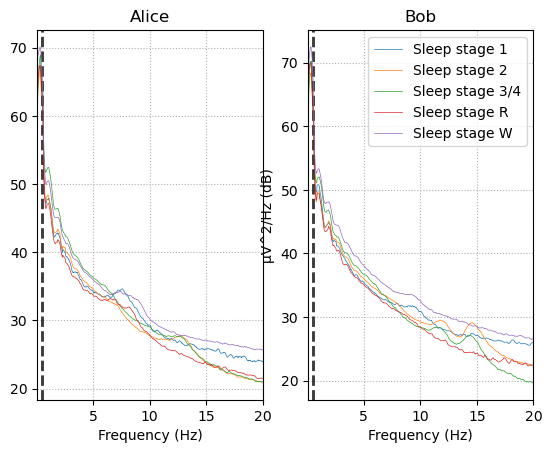

In [11]:
# visualize Alice vs. Bob PSD by sleep stage.
fig, (ax1, ax2) = plt.subplots(ncols=2)

# iterate over the subjects
stages = sorted(event_id.keys())
for ax, title, epochs in zip([ax1, ax2],
                             ['Alice', 'Bob'],
                             [epochs_train, epochs_test]):

    for stage, color in zip(stages, stage_colors):
        epochs[stage].plot_psd(area_mode=None, color=color, ax=ax,
                               fmin=0.1, fmax=20., show=False,
                               average=True, spatial_colors=False)
    ax.set(title=title, xlabel='Frequency (Hz)')
ax2.set(ylabel='µV^2/Hz (dB)')
ax2.legend(ax2.lines[2::3], stages)
plt.show()

### EEG信号から睡眠ステージを予測する関数の作成

In [12]:
def eeg_power_band(epochs):
    """EEG relative power band feature extraction.

    This function takes an ``mne.Epochs`` object and creates EEG features based
    on relative power in specific frequency bands that are compatible with
    scikit-learn.

    Parameters
    ----------
    epochs : Epochs
        The data.

    Returns
    -------
    X : numpy array of shape [n_samples, 5]
        Transformed data.
    """
    # specific frequency bands
    FREQ_BANDS = {"delta": [0.5, 4.5],
                  "theta": [4.5, 8.5],
                  "alpha": [8.5, 11.5],
                  "sigma": [11.5, 15.5],
                  "beta": [15.5, 30]}

    psds, freqs = psd_welch(epochs, picks='eeg', fmin=0.5, fmax=30.)
    # Normalize the PSDs
    psds /= np.sum(psds, axis=-1, keepdims=True)

    X = []
    for fmin, fmax in FREQ_BANDS.values():
        psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
        X.append(psds_band.reshape(len(psds), -1))

    return np.concatenate(X, axis=1)

### Scikit-Learnを使って睡眠ステージを予測する

In [13]:
pipe = make_pipeline(FunctionTransformer(eeg_power_band, validate=False),
                     RandomForestClassifier(n_estimators=100, random_state=42))

# Train
y_train = epochs_train.events[:, 2]
pipe.fit(epochs_train, y_train)

# Test
y_pred = pipe.predict(epochs_test)

# Assess the results
y_test = epochs_test.events[:, 2]


Loading data for 841 events and 3000 original time points ...
0 bad epochs dropped
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Loading data for 1103 events and 3000 original time points ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s finished


0 bad epochs dropped
Effective window size : 2.560 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


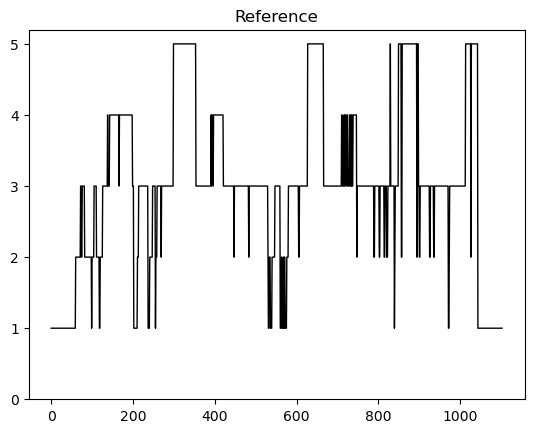

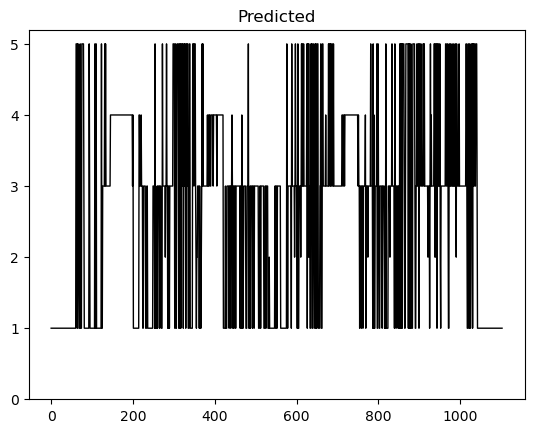

[0 0 0 ... 4 0 2]
Accuracy score: 0.641885766092475


In [14]:
for object in [(y_test, "Reference"), (y_pred, "Predicted")]:
    x = np.array(range(0, len(object[0])))
    y = np.array(object[0])
    plt.title(object[1])
    plt.plot(x, y, color = "black", lw = 1)
    plt.yticks(range(0, 6))
    plt.show()

acc = accuracy_score(y_test, y_pred)

sls = yasa.SleepStaging(raw_test, eeg_name="EEG Fpz-Cz")
hypno_pred = sls.predict()
hypno_pred = yasa.hypno_str_to_int(hypno_pred)
print(hypno_pred)

print("Accuracy score: {}".format(acc))

正確率が64.1%

In [15]:
print(confusion_matrix(y_test, y_pred))

[[156   0   1   0   0]
 [ 80   4   7   2  16]
 [ 85  17 369  33  58]
 [  0   0   5 100   0]
 [ 54   3  34   0  79]]


In [16]:
print(classification_report(y_test, y_pred, target_names=event_id.keys()))

                 precision    recall  f1-score   support

  Sleep stage W       0.42      0.99      0.59       157
  Sleep stage 1       0.17      0.04      0.06       109
  Sleep stage 2       0.89      0.66      0.75       562
Sleep stage 3/4       0.74      0.95      0.83       105
  Sleep stage R       0.52      0.46      0.49       170

       accuracy                           0.64      1103
      macro avg       0.55      0.62      0.54      1103
   weighted avg       0.68      0.64      0.63      1103

